# Optimisation of the stacking sequence for an L-shaped beam
Author: Francesco Caimmi, francesco dot caimmi at polimi dot it

This notebook solves the optimisation problem for the L-shaped beam example presented in the class on Laminate Design Examples during the course "Composite Materials for Structural Applications" by Francesco Caimmi held at the Politecnico di Milano.

The notebook relies on functions from a custom library called `lib4g` that contains functions to work with stiffness matrices of composite materials and to transform stresses and strains into different reference systems,so cannot be used as a standalone notebook. Students that know Python are nonetheless encouraged to write their own functions and use to notebook to explore the problem solution.

The notebook uses the python package [pyopt](http://www.pyopt.org/) to perform the optimization itself.

## Import the needed packages

In [1]:
#this imports numpy and matplotlib
%matplotlib inline 
import numpy as np
import matplotlib.pylab as plt
import pyOpt
#these modules are used to performe the needed trasformation
#of stresses and strains and to calculate the plate elastic properties
#if you want to reuse this notebook you have to define your own function
from lib4g.composites.elastic import mat_trans_2Dstrain_rot#2D strain transformation matrix
from lib4g.composites.elastic import elastic_compliance_2D_pstress#Plane stress compliance matrix from engineering constants
from lib4g.composites.lamination_theory import clt_ABD#ABD matrix according to CLT
from lib4g.composites.failure import tsai_hill#calculates Tsai-Hill failure index

## Define the problem data
The units are N, mm and MPa

In [2]:
#material data
E1,E2,v12,G12 = 140e3, 10e3, 0.03, 5.1e3
X, Y, S = 2100, 75, 90
#geometry
l1, l2 = 10e3, 1e3
B = 100
#load
P = 1000
Mxy = P*l2/B
Mx = P*l1/B
M = np.array([Mx,0.0,Mxy])
#safety factor
eta = 1.4
#cured ply thickness
cpt = 0.3
#Evaluate the layer properties
C = elastic_compliance_2D_pstress(E1,E2,v12,G12)
Q = np.linalg.inv(C)


## Define the objective and constraints functions

Formally the problem to solve can be stated as:

$$
\begin{align}
    %line 1
    x=\underset{x}{\operatorname{arg\,min}} \quad &  
    h\,(x) \\
    %line 2
    \text{s.t.} \quad &  \max F \,(x,z,s) \leq 1/\eta\\
\end{align}
$$

i.e. find the minimum height of the laminate $h$ at varying the lamination sequence, $x$, such that the maximum value of the Tsai-Hill failure index at varying the curvilinear abcissa along the beam axis $s$ and the through the thickness position $z$ is less than $1/\eta$.

The lamination sequence is an array made by the variables $L/2$, an integer variable representing half the number of layers (we assume symmetric lamination sequence), and a variable number of integers values $t_i$ that can vary in the range $[-5,6]$, which represents angles $\theta_i$ (with $i \text{ in } [1,L]$) that can vary between -75 and 90 with a discrete increment of 15 degrees. 
This is done to simulate the fact that rarely in production the angles can be actually varied continuosly, especially for instance if lamination is done manually.
Note that all the design variables are integers.
To further simplify the problem, it shall be assumed that the most dangerous location is at $s=0$, i.e. at the built-in end.

In the pyopt framework, both the objective function $o(x)=h(x)$ and the constraint function $g(x)=F(x)-1/\eta$ are defined in a single function which returns both of them.


In [3]:
def objfunc(x):
    """
    This function returns the objective function and the constraints,
    in compliance with the specifications of the package pyopt

    Parameters
    ------------
    x: np array
        x[0] the number of layers L in a symmetric lamination sequence (int)
        x[1:]the angles (ints)
        The lamination sequence is assumed to be symmetric. Angles vary in [-5,6] which is internally mapped to [-75,90] 
        degrees.

    Returns
    -------
    f: float
        the objective function (height)

    g: array
        a one component array containing the value of F, the Tsai-Hill failure
        index

    fail: int
        an evaluation failure index (here we always return 0)

    """

    fail = 0#this should be changed if objfunc evaluation fails, but for this simple example we do no bother checking
    #DEFINE THE OBJECTIVE FUNCTION
    #i.e. the height of the laminate
    L = int(2*x[0])
    t = 15.0*x[1:x[0]+1:1]
    thetas = np.deg2rad(t)#convert to radians
    hs = [cpt for i in range(L/2)]#heights of each layer, symmetric
    hf = hs+hs[::-1]#array with the height of each layer
    f = 2*np.sum(hs)#objective function

    #DEFINE THE CONSTRAINT FUNCTION
    #initialize g, a vector of one component since we only have a single constraint
    g = [0]
    #evaluate the layer interface positions
    Z = np.zeros(L+1)
    Z[0] = -f/2.0
    for j in range(L):
        Z[j+1] = hf[j]+Z[j]

    A,dump,D = clt_ABD(hs,Q,t)#A,B,D matrix
    #generalized deformations
    chi = np.dot(np.linalg.inv(D),M)

    #_for each layer lets calulate the maximum value of the Tsai-Hill index
    Flayers = np.zeros_like(thetas, dtype=float)#variable to store the results

    for k,theta in enumerate(thetas):#for each layer
        #calculate the strains ath the top and bottom of the layer
        eps_top = Z[k+1]*chi
        eps_bot = Z[k]*chi
        #transform the strains in the PMRS
        Te = mat_trans_2Dstrain_rot(np.deg2rad(theta))
        eps_top12 = np.dot(Te, eps_top)
        eps_bot12 = np.dot(Te, eps_bot)
        #get the stresses
        sigma_top = np.dot(Q, eps_top12)
        sigma_bot = np.dot(Q, eps_bot12)
        #get Tsai-Hill index
        Ftop = tsai_hill(sigma_top, [X,Y,S])
        Fbot = tsai_hill(sigma_bot, [X,Y,S])
        #take the largest and store it
        Flayers[k] = np.max([Ftop,Fbot])
    
    #calculate the value of the constraint function g(x)
    #inequality constraints are defined as g(x)<=0 so everythong must be on the left of the < sign
    #take the maximum of F at varying the layer
    g[0] = np.max(Flayers)-1/eta

    return f, g, fail

## Explore the objective function
We can look at hypersections of the objective function to try to define bounds on the design space to simplify
the solution of the problem.

Let's take a look at what happens with a laminate made by layers at $\pm 45$ only

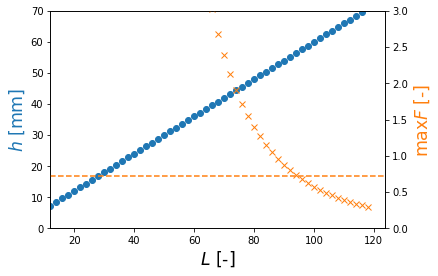

In [4]:
Lmax_2 = 60
o1 = np.empty(Lmax_2-1)
g1 = np.empty(Lmax_2-1)
Ls = np.arange(1,Lmax_2)
for i in Ls:
    t = np.array(i*[3,-3])
    res = objfunc(np.concatenate(([i*2],t)))
    o1[i-1], g1[i-1] = res[0], res[1][0] 
plt.plot(2*Ls,o1,'o',label='$h(x)$')
ax1 = plt.gca()
plt.xlabel('$L$ [-]',fontsize='xx-large')
plt.ylabel('$h$ [mm]',fontsize='xx-large',color='C0')
plt.ylim(0,70);
ax2 = ax1.twinx()
plt.plot(2*Ls,g1+1/eta,'x',label='$\max F(x)$',color='C1')
plt.axhline(y=1/eta,linestyle='dashed',color='C1')
ax2.set_ylabel('$\max F$ [-]',fontsize='xx-large', color='C1')
lims=plt.xlim()
plt.xlim(12,lims[1])
lims=plt.ylim()
plt.ylim(0,3);

Obviously $h$ increases with $L$ for a fixed lamination sequence; $F$ decreases with thickness as well. 

We can also look at what happens when we vary the angle of the outermost layers in a lamination sequence like $[ \theta_{1} {}_{n} ,\pm 30_{18} ]_s$ with the number of outermost layers $n$ also varying. 
By looking at many different sequences we can get an idea of what is going on.

In [5]:
nmax=24
nmin=6
nthirty = 18#number of layers at 30 and -30 (the total at +/-30 is twice this)
angleply=2 #angle of the angle ply layers
t = np.arange(-5,6,1)
ns = np.arange(nmin,nmax)
x,y = np.meshgrid(ns,t) #numebr of layer at zero X num angles
G = np.empty_like(x, dtype=float)
O = np.empty_like(x, dtype=float)
imax, jmax = x.shape
for i in range(imax):
    for j in range(jmax):
        p = np.concatenate(([x[i,j]+nthirty*2], np.array(x[i,j]*[y[i,j]]),np.array(nthirty*[angleply,-angleply])))
        res = objfunc(p)
        O[i,j] = res[0]
        G[i,j] = res[1][0]

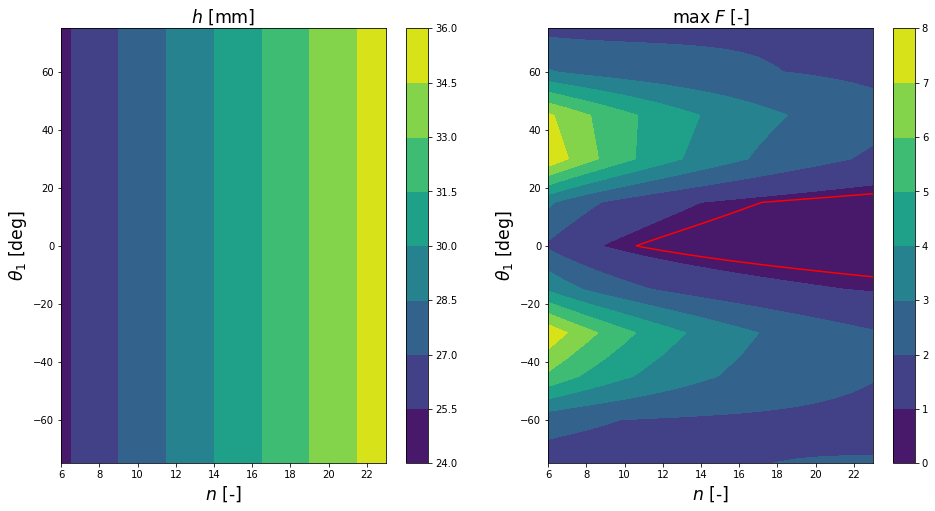

In [6]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)#left plot of the objective function
plt.contourf(x,15*y,O)
plt.colorbar()
plt.xlabel('$n$ [-]', fontsize='xx-large')
plt.ylabel('$\\theta_1$ [deg]', fontsize='xx-large')
plt.title('$h$ [mm]', fontsize='xx-large')
plt.subplot(1,2,2)#right plot,Tsai-Hill criterion
plt.contourf(x,15*y,G+1/eta)
plt.colorbar()
plt.title('$\\max \\; F$ [-]', fontsize='xx-large')
plt.xlabel('$n$ [-]', fontsize='xx-large')
plt.ylabel('$\\theta_1$ [deg]', fontsize='xx-large')
plt.contour(x,15*y,G+1/eta,[1/eta],colors=('r',), linewidth=6)#this is the red line identyfing the safe zone

## Solve the optimization problem
This is done by defining the problem according to the rules of the pyopt package. We use the Augmented Lagrangian Particle 
Swarm Optimizer [ALPSO](http://www.pyopt.org/reference/optimizers.alpso.html) to solve the problem beacuse
we are defining all the variables as integers, and this solver supports integer programming. As you can note, problem definition and solution is straightforward.

In [21]:
    Lmax=50#maximum number of layers allowed, symmetric stackin sequence
    #define the optimization problem. See the pyopt package documentation
    #for the details http://www.pyopt.org/
    problem = pyOpt.Optimization('L-shaped beam', objfunc)
    #define the objective function name
    problem.addObj('f')
    #define the problem variables (of integer type)
    problem.addVar('L',type='i', lower=20, upper=Lmax)
    for i in range(Lmax):
        problem.addVar('t'+str(i+1), type='i', lower=-5, upper=6)
    #add the inequality type Tsai-Hill constraint
    problem.addCon('Tsai-Hill', type='i')

    #define the solver, a particle swarm one in this case
    solver = pyOpt.pyALPSO.ALPSO()

    #set the solver options, see
    #http://www.pyopt.org/reference/optimizers.alpso.html for details

    solver.setOption('SwarmSize',130)
    solver.setOption('maxOuterIter',450)
    solver.setOption('maxInnerIter',9)
    #solve the optimization problem
    [fstr, xstr, inform] = solver(problem)

    #print the results to stdout and to a file
    print(problem.solution(0))
    np.savetxt('lbeam.optimal-ALPSO.txt',xstr)

## Results
we explore the objective function in the neighborhood of the minimum,by varing the angles $\theta_1$ and $\theta_{15}$

In [7]:

try:
    xopt = np.array(problem.solution(0))
except NameError:
    #the problem solution, can be read without solving the problem anew, if solved at least once on your machine
    xopt = np.genfromtxt('lbeam.optimal-ALPSO.txt')
    xopt = np.array(xopt, dtype='int')

In [8]:
step=1
thetas = np.arange(-5,6+step,step)
x,y = np.meshgrid(thetas,thetas)
G = np.empty_like(x, dtype=float)
O = np.empty_like(x, dtype=float)
imax, jmax = x.shape
p = xopt#set point to be evaluted equal to xopt
for i in range(imax):
    for j in range(jmax):
        p[1] = x[i,j] #this is theta1
        p[15] = y[i,j]#this is theta15;change the value to change the layer 
        res = objfunc(p)
        O[i,j] = res[0]
        G[i,j] = res[1][0]

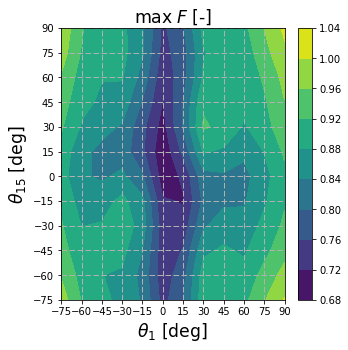

In [9]:
#plot the results
plt.figure(figsize=(5,5))
plt.contourf(15*x,15*y,G+1/eta)
plt.colorbar()
plt.xlabel('$\\theta_{1}$ [deg]', fontsize='xx-large')
plt.ylabel('$\\theta_{15}$ [deg]', fontsize='xx-large')
plt.xticks(15*np.arange(-5,7))
plt.yticks(15*np.arange(-5,7))
plt.title('$\\max \\; F$ [-]', fontsize='xx-large')
plt.grid(linestyle='--', linewidth=1)
plt.savefig('lbeam-Fmax-contour.pdf', bbox_inches='tight')

As it can be seen, for given $\theta_1$ the result is almost insesitive to $\theta_{15}$, i.e. independent of
the lamination sequence,except for values of $\theta_1$ close to $90^\circ$. This suggests that a good sandwich may 
be an alternative structure.